In [126]:
from keras.losses import SparseCategoricalCrossentropy
import zipfile
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import (Rescaling,Reshape,Resizing,InputLayer,MaxPool2D,AveragePooling2D,Conv2D,
                                     Flatten,Dropout,BatchNormalization,Dense)
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.metrics import (Accuracy,SparseCategoricalAccuracy,CategoricalAccuracy,TopKCategoricalAccuracy)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

files.upload() #this will prompt you to upload the

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aksh2704","key":"6775788223fc875ad4415ea43b797876"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 May 29 14:40 kaggle.json


In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 96% 297M/309M [00:02<00:00, 134MB/s]
100% 309M/309M [00:02<00:00, 111MB/s]


In [8]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [9]:
train_datapath="/content/dataset/Emotions Dataset/Emotions Dataset/train/"
val_datapath="/content/dataset/Emotions Dataset/Emotions Dataset/test/"
CLASS_NAME=["angry","happy","sad"]

In [10]:
CONFIGURATION={
    "BATCH_SIZE":32,
    "IMG_SIZE":256,
    "CLASS_NAMES": ["angry", "happy", "sad"],
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0,
    "N_FILTERS": 16,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,

}

##**Dataset Loading**

In [11]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    directory=train_datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [12]:
val_dataset=tf.keras.utils.image_dataset_from_directory(
    directory=val_datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


##**Dataset Preperation**

In [13]:
training_dataset=(
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
val_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [15]:
training_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [16]:
print(len(train_dataset))

213


In [17]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
print(len(val_dataset))

72


In [19]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
       Rescaling(1./255),                 
])

##**Dataset Visualization**

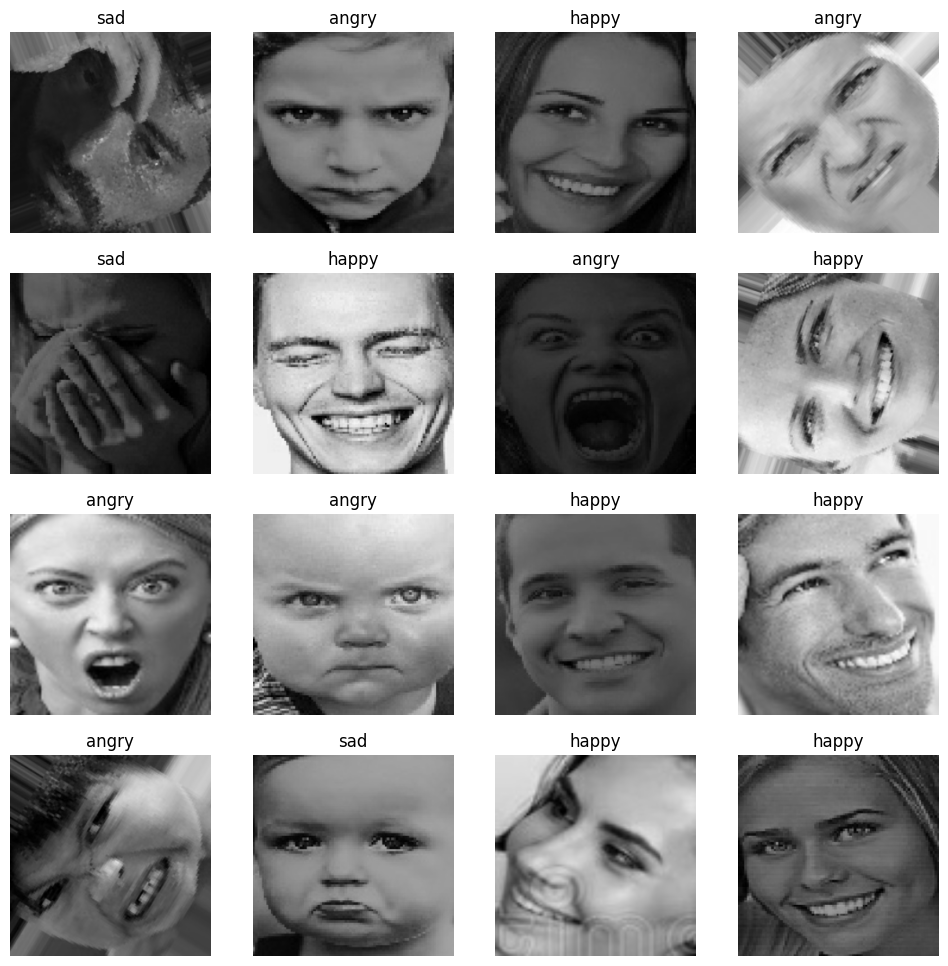

In [20]:
plt.figure(figsize=(12,12))

for image,labels in train_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i],axis=-1).numpy()])
    plt.axis("off")

In [21]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 36)     

In [22]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [23]:
lenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]),
                    metrics=["accuracy"])

In [24]:
for name,label in training_dataset.take(1):
  print(len(label.shape))

2


In [25]:
history_1=lenet_model.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=20,
                          verbose=1)

Epoch 1/20
213/213 [==============================] - 41s 100ms/step - loss: 7.8356 - accuracy: 0.4908 - val_loss: 14.9276 - val_accuracy: 0.4254
Epoch 2/20
213/213 [==============================] - 21s 96ms/step - loss: 0.8843 - accuracy: 0.6069 - val_loss: 7.3809 - val_accuracy: 0.3999
Epoch 3/20
213/213 [==============================] - 21s 97ms/step - loss: 0.6534 - accuracy: 0.7173 - val_loss: 0.8696 - val_accuracy: 0.6681
Epoch 4/20
213/213 [==============================] - 21s 97ms/step - loss: 0.4761 - accuracy: 0.8050 - val_loss: 1.0006 - val_accuracy: 0.6844
Epoch 5/20
213/213 [==============================] - 22s 102ms/step - loss: 0.3783 - accuracy: 0.8604 - val_loss: 1.3947 - val_accuracy: 0.5549
Epoch 6/20
213/213 [==============================] - 21s 99ms/step - loss: 0.3574 - accuracy: 0.8707 - val_loss: 1.0606 - val_accuracy: 0.7068
Epoch 7/20
213/213 [==============================] - 20s 94ms/step - loss: 0.2121 - accuracy: 0.9225 - val_loss: 1.2243 - val_accura

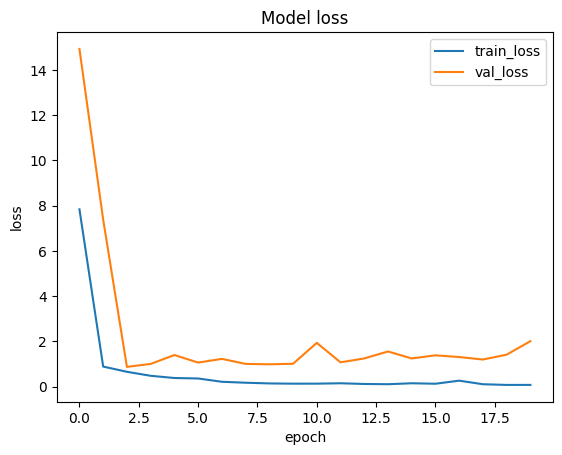

In [26]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

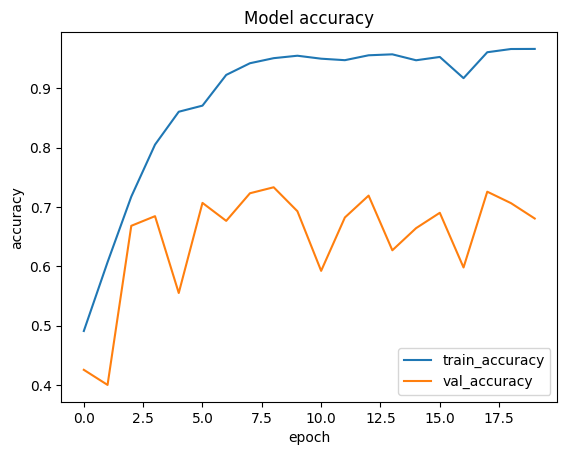

In [27]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [28]:
evaluate=lenet_model.evaluate(val_dataset)

72/72 [==============================] - 3s 37ms/step - loss: 2.0064 - accuracy: 0.6804


##**Testing Image**

In [29]:

from google.colab.patches import cv2_imshow
test_image=cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/126093.jpg")

img=tf.constant(test_image,dtype=tf.float32)
img=tf.expand_dims(img,axis=0)
label=lenet_model(img)
print(label)
prediction=CLASS_NAME[tf.argmax(label,axis=-1).numpy()[0]]
prediction

tf.Tensor([[4.378058e-06 9.992182e-01 7.773304e-04]], shape=(1, 3), dtype=float32)


'happy'

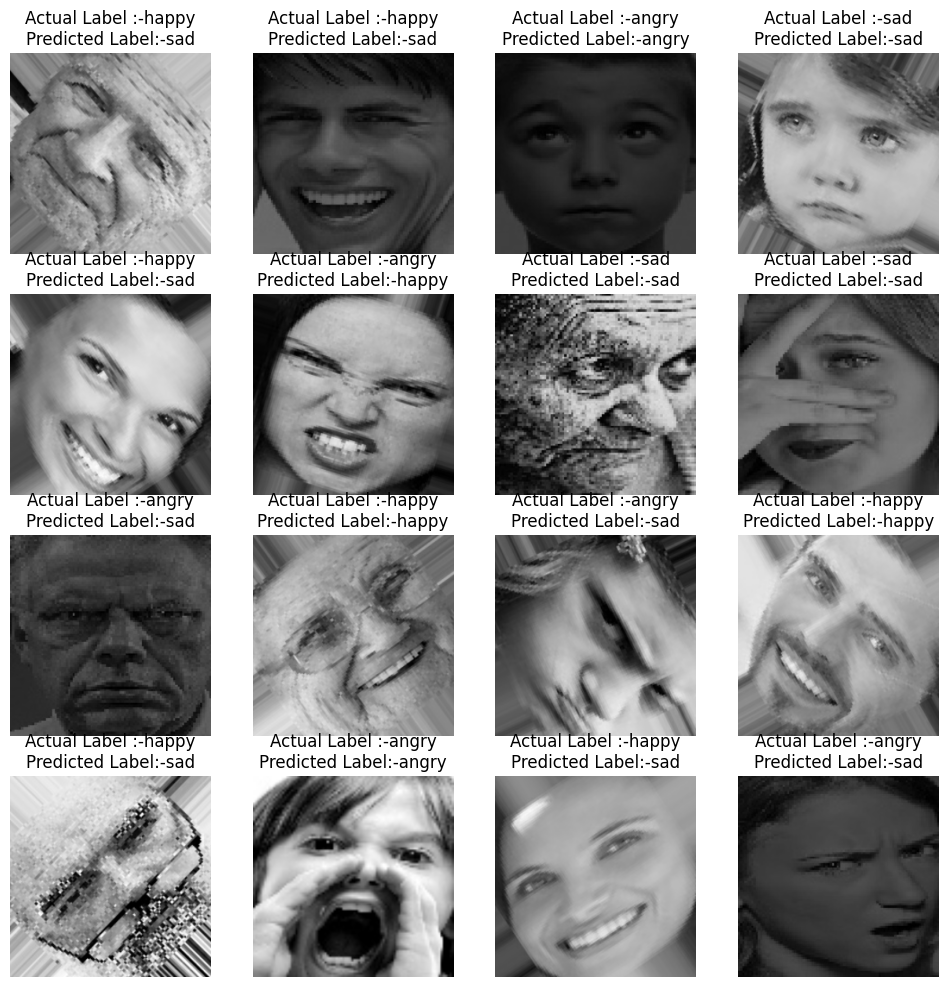

In [30]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(lenet_model(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [84]:
preds=[]
actual=[]

for im,label in val_dataset:
  actual.append(label.numpy())
  preds.append(lenet_model(im).numpy())

In [85]:
print(np.argmax(preds[:-1],axis=-1).flatten())
print(np.argmax(actual[:-1],axis=-1).flatten())

[2 2 1 ... 2 2 1]
[1 2 1 ... 2 1 1]


In [86]:
preds=np.concatenate((np.argmax(preds[:-1],axis=-1).flatten(),(np.argmax(preds[-1],axis=-1).flatten())),axis=0)
labels=np.concatenate((np.argmax(actual[:-1],axis=-1).flatten(),np.argmax(actual[-1],axis=-1).flatten()),axis=0)

In [87]:

preds.shape

(2278,)

In [88]:
labels.shape

(2278,)

In [89]:
cm=confusion_matrix(labels,preds)
print(cm)

[[215  72 228]
 [ 15 679 312]
 [ 25  76 656]]


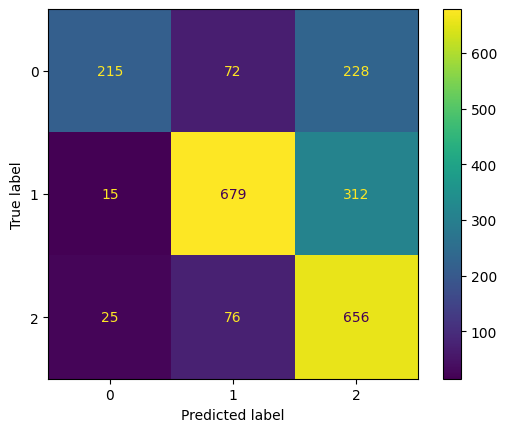

In [90]:
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

##**Improving score by Data Augmentation**

In [96]:
augment_layers = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [97]:
def augment_layer(image,label):
  return augment_layers(image,training=True),label

In [98]:
training_dataset_aug=(
    train_dataset
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [99]:
val_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [100]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
       Rescaling(1./255),                 
])

##**Dataset Visualization**

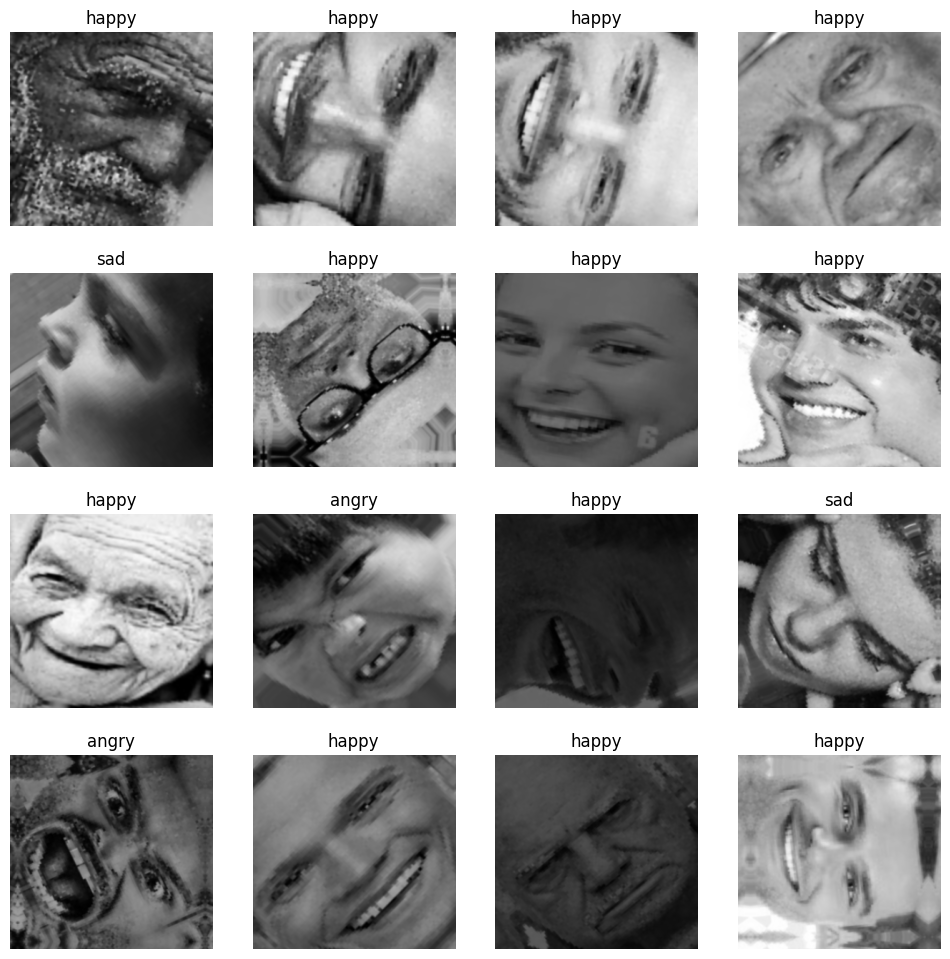

In [101]:
plt.figure(figsize=(12,12))

for image,labels in training_dataset_aug.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i],axis=-1).numpy()])
    plt.axis("off")

In [102]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_2 (Batc  (None, 254, 254, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 36)     

In [103]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [104]:
lenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]),
                    metrics=["accuracy"])

In [106]:
for name,label in training_dataset_aug.take(1):
  print(len(label))

32


In [107]:
history_1=lenet_model.fit(training_dataset_aug,
                          validation_data=val_dataset,
                          epochs=20,
                          verbose=1)

Epoch 1/20
213/213 [==============================] - 88s 392ms/step - loss: 5.9361 - accuracy: 0.4414 - val_loss: 1.0852 - val_accuracy: 0.4399
Epoch 2/20
213/213 [==============================] - 85s 399ms/step - loss: 1.0591 - accuracy: 0.4755 - val_loss: 1.1384 - val_accuracy: 0.4486
Epoch 3/20
213/213 [==============================] - 84s 392ms/step - loss: 1.0027 - accuracy: 0.5157 - val_loss: 1.1372 - val_accuracy: 0.4934
Epoch 4/20
213/213 [==============================] - 85s 391ms/step - loss: 0.9865 - accuracy: 0.5067 - val_loss: 0.9532 - val_accuracy: 0.5119
Epoch 5/20
213/213 [==============================] - 84s 393ms/step - loss: 0.9609 - accuracy: 0.5401 - val_loss: 0.9145 - val_accuracy: 0.5597
Epoch 6/20
213/213 [==============================] - 84s 393ms/step - loss: 0.9358 - accuracy: 0.5486 - val_loss: 1.0058 - val_accuracy: 0.5452
Epoch 7/20
213/213 [==============================] - 82s 383ms/step - loss: 0.9380 - accuracy: 0.5645 - val_loss: 1.0364 - val_ac

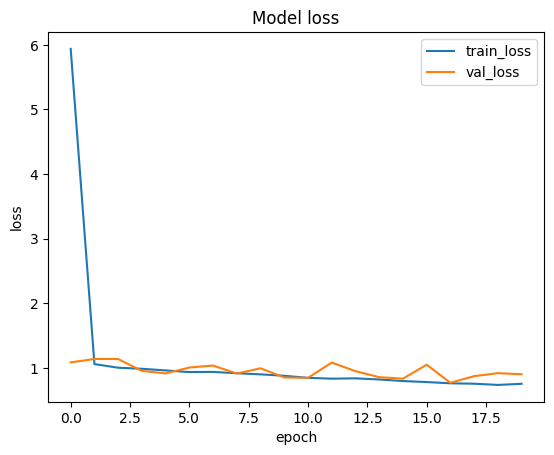

In [108]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

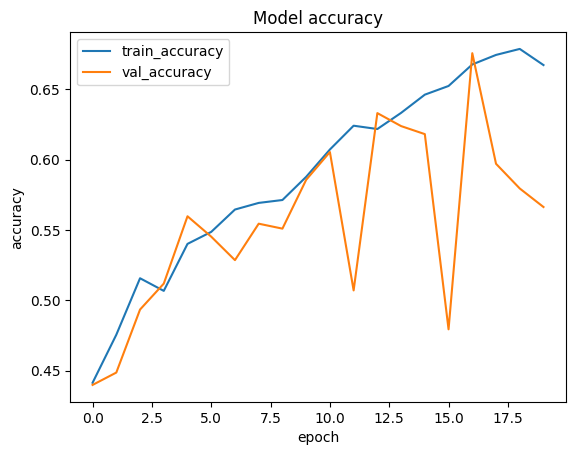

In [109]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [110]:
evaluate=lenet_model.evaluate(val_dataset)

72/72 [==============================] - 3s 37ms/step - loss: 0.9014 - accuracy: 0.5663


##**Testing Image**

In [111]:

from google.colab.patches import cv2_imshow
test_image=cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/126093.jpg")

img=tf.constant(test_image,dtype=tf.float32)
img=tf.expand_dims(img,axis=0)
label=lenet_model(img)
print(label)
prediction=CLASS_NAME[tf.argmax(label,axis=-1).numpy()[0]]
prediction

tf.Tensor([[0.30042192 0.3275534  0.37202471]], shape=(1, 3), dtype=float32)


'sad'

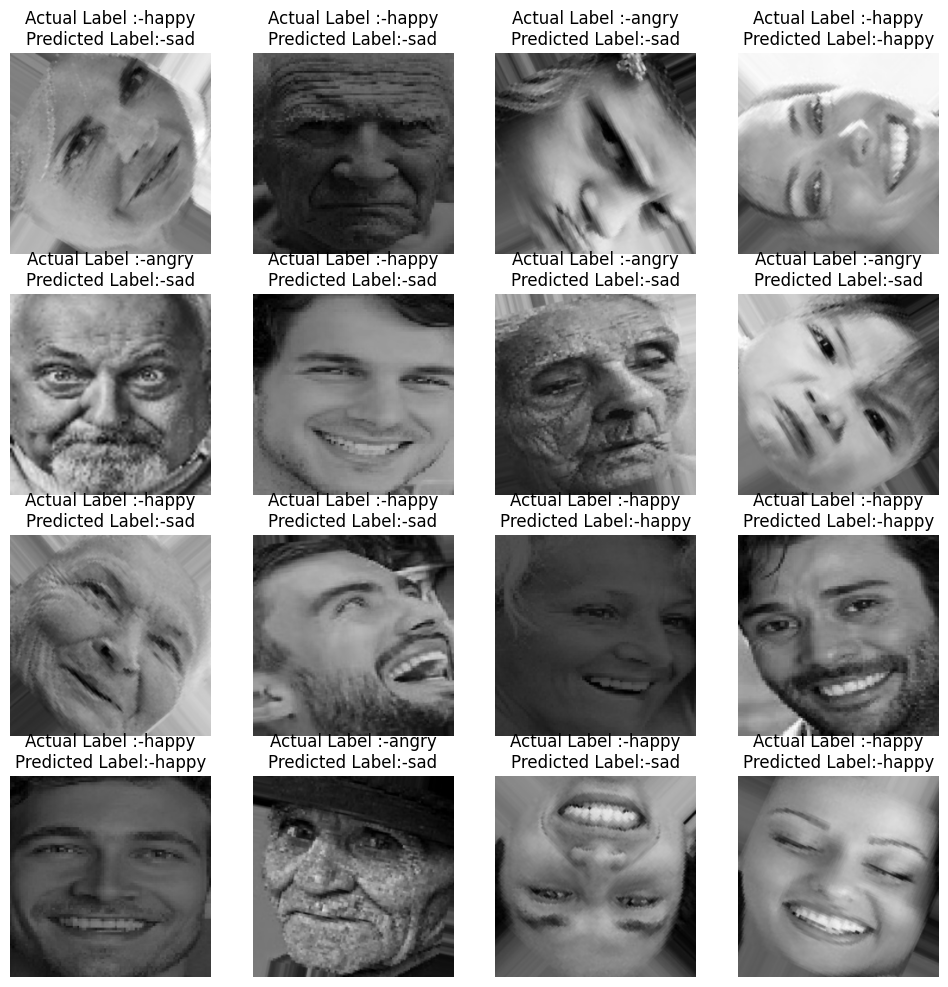

In [112]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(lenet_model(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [113]:
preds=[]
actual=[]

for im,label in val_dataset:
  actual.append(label.numpy())
  preds.append(lenet_model(im).numpy())

In [114]:
print(np.argmax(preds[:-1],axis=-1).flatten())
print(np.argmax(actual[:-1],axis=-1).flatten())

[2 2 2 ... 2 2 0]
[0 0 1 ... 0 1 1]


In [115]:
preds=np.concatenate((np.argmax(preds[:-1],axis=-1).flatten(),(np.argmax(preds[-1],axis=-1).flatten())),axis=0)
labels=np.concatenate((np.argmax(actual[:-1],axis=-1).flatten(),np.argmax(actual[-1],axis=-1).flatten()),axis=0)

In [116]:

preds.shape

(2278,)

In [117]:
labels.shape

(2278,)

In [118]:
cm=confusion_matrix(labels,preds)
print(cm)

[[137  61 317]
 [ 27 476 503]
 [ 16  64 677]]


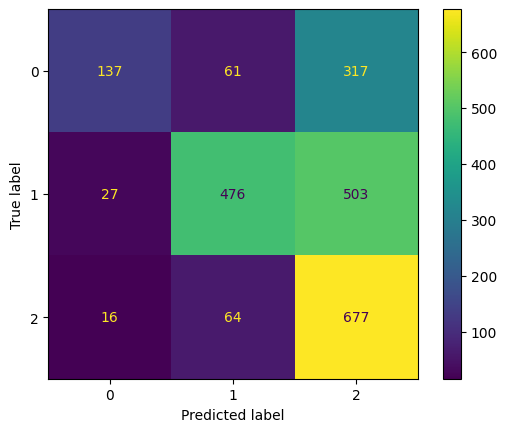

In [119]:
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

###**Model perform poorly with data augmentation**